In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from numpy.testing.print_coercion_tables import print_cancast_table
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import KNNImputer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, dendrogram
from math import ceil
import re

from sympy import reduced
from torch.export import export_for_training

In [2]:
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_colwidth = 100
pd.options.display.max_columns = 50

## 1. Data Cleanup

### 1.1 Data Import 

In [3]:
data = pd.read_csv("../data/BGG_Data_Set.csv", sep=";", header=0)

### 1.2 Rough Cleaning: Dropping of colums, duplicate datapoints, correcting DTypes

In [4]:
data = data.drop(columns=['ID'], axis=1)

In [5]:
init_shape = data.shape[0]
data = data.drop_duplicates()
print(f"Dropped {init_shape - data.shape[0]} duplicate rows")

Dropped 3 duplicate rows


In [6]:
def clean_play_time(value):
    try:
        # If it's already a number, return as-is
        if isinstance(value, (int, float)):
            return value
        # Remove non-numeric characters and attempt conversion
        if isinstance(value, str):
            value = value.strip().lower()
            word_to_num = {
                'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5,
                'six': 6, 'seven': 7, 'eight': 8, 'nine': 9, 'ten': 10,
                'eleven': 11, 'twelve': 12}

            # Find a number or number word in the string
            match = re.search(r'\b(\d+|one|two|three|four|five|six|seven|eight|nine|ten|eleven|twelve)\b', value,
                              re.IGNORECASE)
            if not match:
                return np.nan

            number_str = match.group().lower()
            # Convert number word to integer, if necessary
            number = int(number_str) if number_str.isdigit() else word_to_num.get(number_str, None)

            if number is None:
                return np.nan  # or raise ValueError("Invalid number format")

            # Check for 'hour' or 'hours' in the string
            if 'hour' in value:
                return number * 60  # Convert hours to minutes

            # Default case: Assume the number is already in minutes
            return number
    except:
        return np.nan


def clean_min_players(value: int):
    return np.nan if value < 1 else value


def clean_max_players(row):
    if row['Max Players'] < 1:
        return np.nan
    if not pd.isna(row['Min Players']) and row['Max Players'] < row['Min Players']:
        return np.nan
    return row['Max Players']


def clean_numerics(value):
    if isinstance(value, str):
        # Remove any non-numeric characters (except the dot for decimal numbers)
        cleaned_value = ''.join(c for c in value if c.isdigit() or c in [',', '.'])
        cleaned_value = cleaned_value.replace(',', '.')

        # If there is any valid number left after cleaning, return as float
        if cleaned_value:
            try:
                return float(cleaned_value)
            except ValueError:
                return np.nan  # If conversion fails, return None
    elif isinstance(value, (int, float)):
        return value  # Return the value as-is if it's already numeric

    return np.nan  # Return None for other cases (e.g., None, non-numeric strings)


def transform_into_lists(value):
    if isinstance(value, str):
        # Split the string by commas, strip leading/trailing spaces from each item
        return [item.strip() for item in value.split(',')]
    return []  # Return an empty list for non-string values or empty strings


data['Year Published'] = pd.to_numeric(data['Year Published'], errors='coerce')

data['Min Players'] = data['Min Players'].apply(clean_min_players)
data['Max Players'] = data.apply(clean_max_players, axis=1)

data['Play Time'] = data['Play Time'].apply(clean_play_time)
data['Rating Average'] = data['Rating Average'].apply(clean_numerics)
data['Complexity Average'] = data['Complexity Average'].apply(clean_numerics)

data['Mechanics'] = data['Mechanics'].apply(transform_into_lists)
data['Domains'] = data['Domains'].apply(transform_into_lists)

## 2. Data Analysis and Cleaning
### 2.1 General Statistics

In [7]:
def show_gen_stats(data: pd.DataFrame):
    general_stats = data.describe().T

    # Remove the 25/50/75% columns, as these will be shown in the boxplots
    delete_cols = ['25%', '50%', '75%']
    general_stats = general_stats.drop(delete_cols, axis=1)
    # Convert the 'count' column to a percentage of NaNs and rename the column
    general_stats['perc missing'] = 100 * (1 - general_stats['count'] / data.shape[0])
    general_stats['amount missing'] = data.shape[0] - general_stats['count']

    styled_general_stats = general_stats.style.background_gradient(cmap='Blues', axis=None,
                                                                   subset=['perc missing', 'amount missing'])
    styled_general_stats = styled_general_stats.background_gradient(cmap='Greens', axis=None, subset=['mean', ])
    styled_general_stats = styled_general_stats.background_gradient(cmap='Reds', axis=None, subset=['std', ])
    styled_general_stats = styled_general_stats.background_gradient(cmap='Purples', axis=None, subset=['min', ])
    styled_general_stats = styled_general_stats.background_gradient(cmap='Greys', axis=None, subset=['max', ])
    # Set a format for each column (amount of digits after the comma)

    display(styled_general_stats.format({
        'count': '{:,.2f}',
        'perc missing': '{:,.2f}',
        'amount missing': '{:,.0f}',
        'mean': '{:.2f}',
        'std': '{:.2f}',
        'min': '{:.2f}',
        'max': '{:.2f}'})
    )
    return general_stats


general_stats = show_gen_stats(data)

,count,mean,std,min,max,perc missing,amount missing
Year Published,"18,304.00",1984.31,214.81,-3500.00,2022.00,10.02,"2,039"
Min Players,"20,294.00",2.03,0.98,1.00,100.00,0.24,49
Max Players,"20,179.00",5.72,15.30,1.00,999.00,0.81,164
Play Time,"18,309.00",90.41,541.86,0.00,60000.00,10.00,"2,034"
Min Age,"20,343.00",9.62,3.89,0.00,150.00,0.00,0
Users Rated,"20,343.00",840.97,3511.56,30.00,102214.00,0.00,0
Rating Average,"18,309.00",6.40,0.93,1.05,9.54,10.00,"2,034"
BGG Rank,"20,343.00",10172.89,5872.83,1.00,20344.00,0.00,0
Complexity Average,"20,343.00",1.99,0.85,0.00,5.00,0.00,0
Owned Users,"20,320.00",1408.46,5040.18,0.00,155312.00,0.11,23


### 2.2 Boxplots

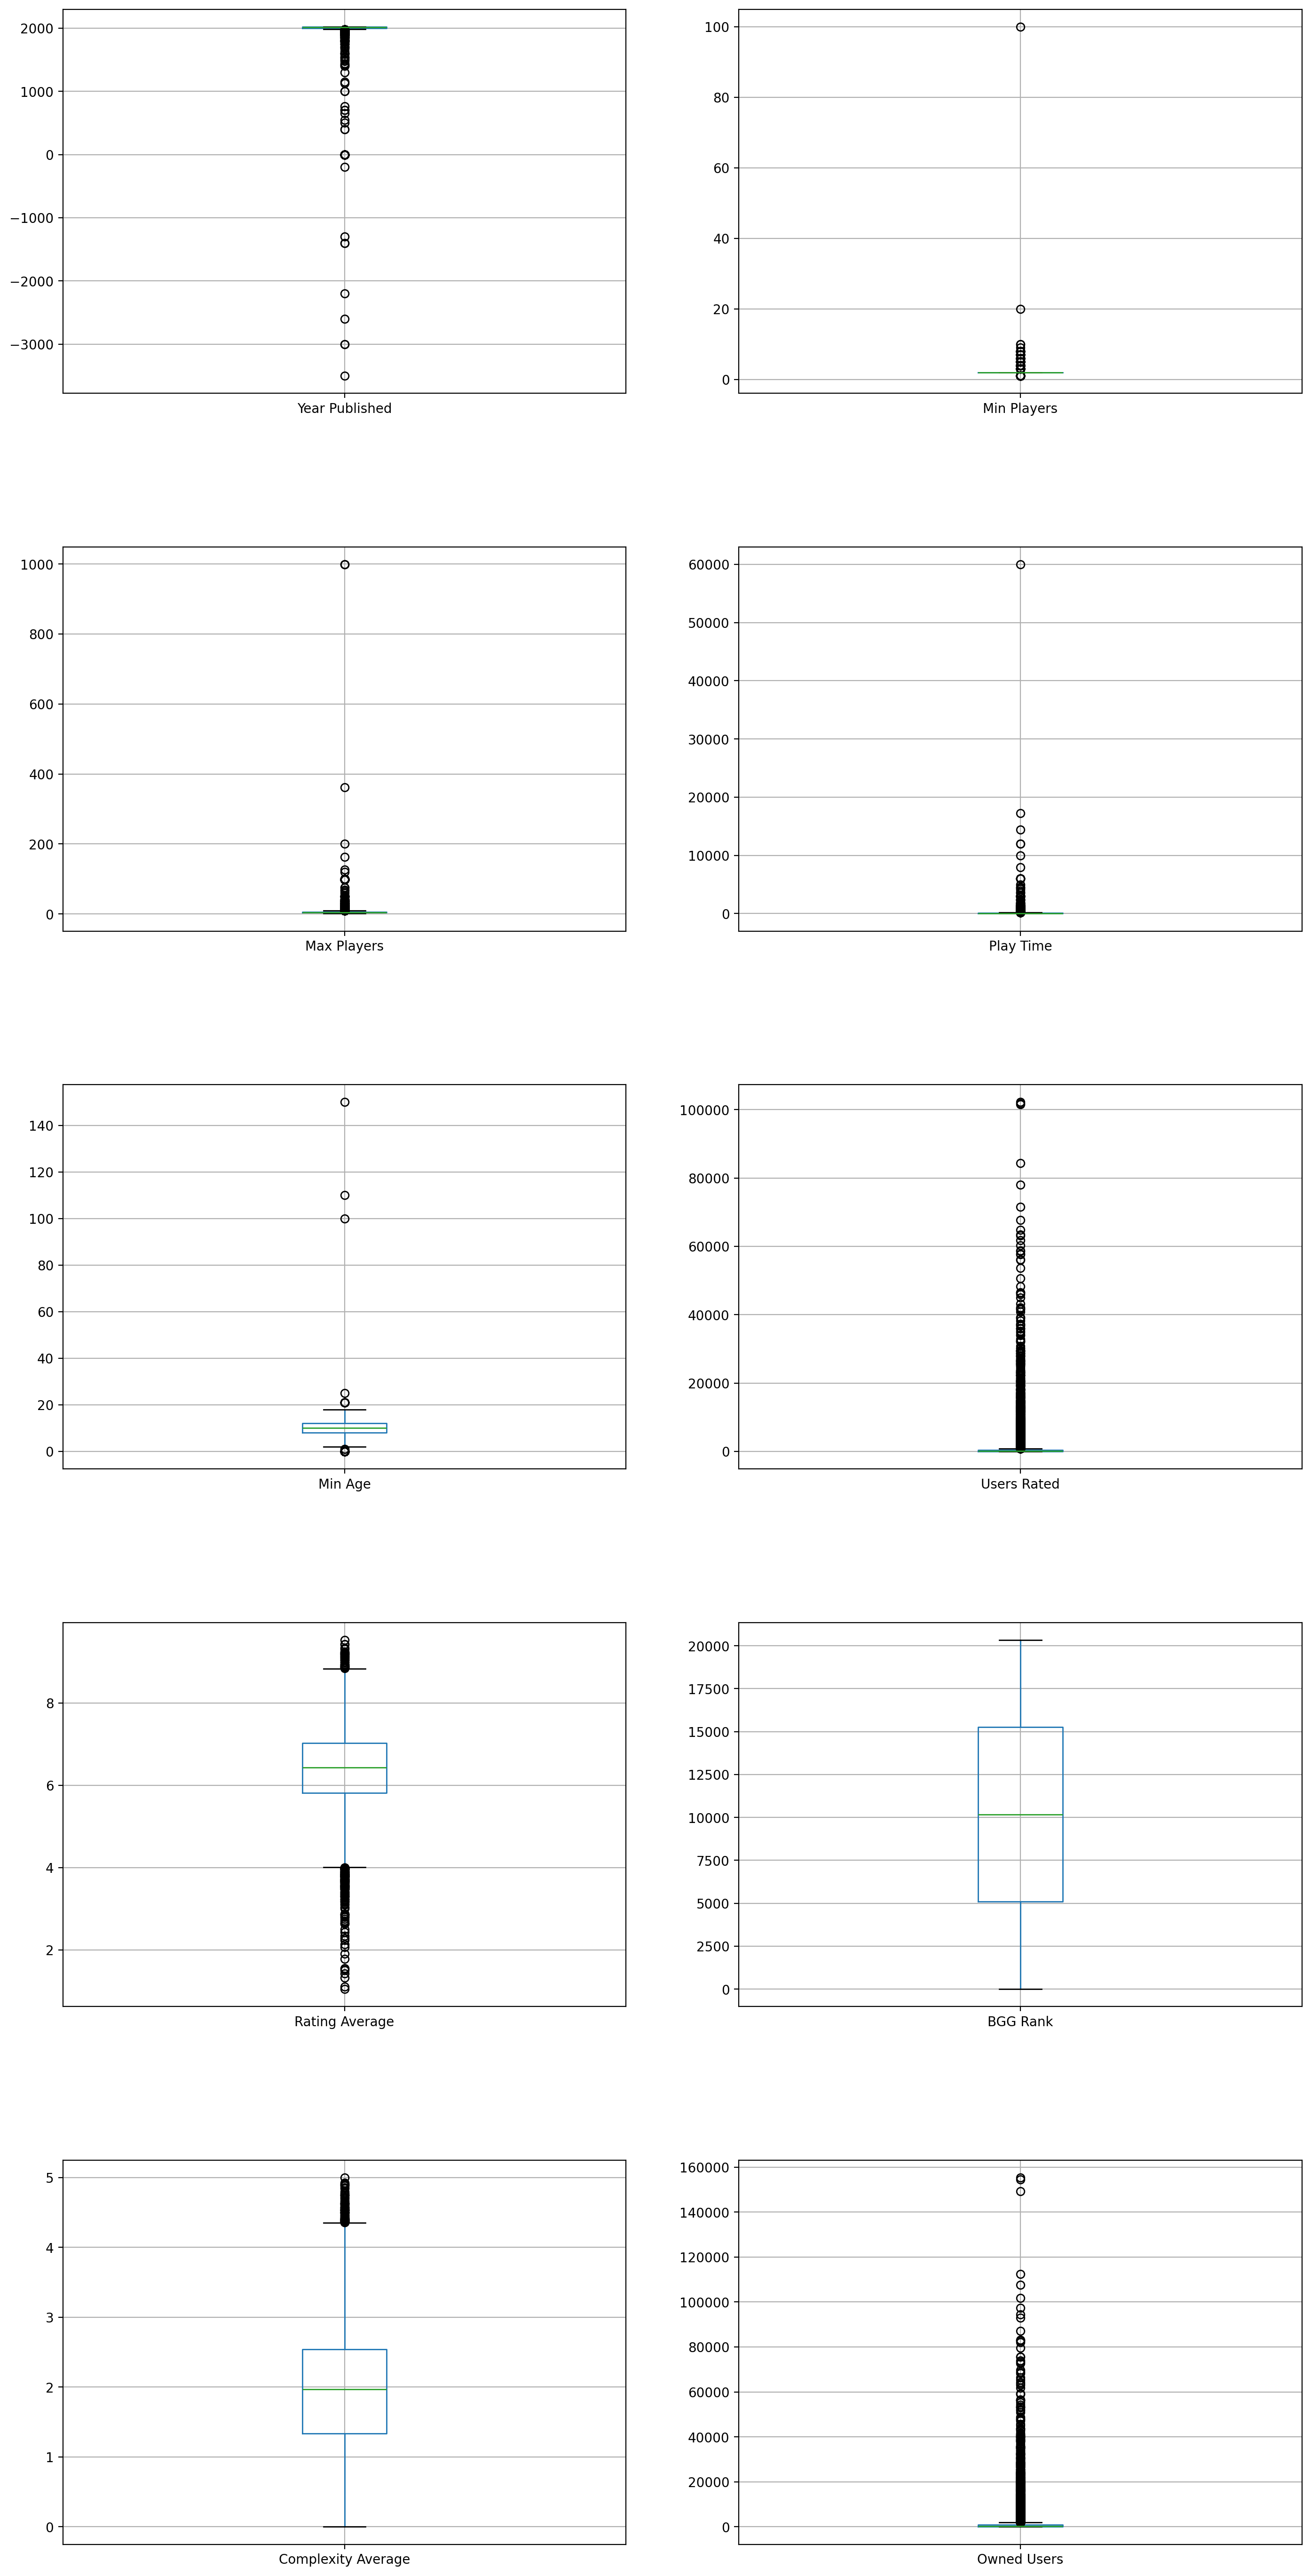

In [8]:
# The amount of sub-plot columns and rows in the output plot
fig_cols = 2
fig_rows = ceil(len(general_stats) / fig_cols)
grid = (fig_rows, fig_cols)

# Create Figure and axes objects
fig, ax = plt.subplots(*grid, figsize=(17, 35), gridspec_kw={'hspace': .4})
# The axes that will be used
used_axes = ax[np.unravel_index(range(len(general_stats)), grid)]

#Make one boxplot per unit of measure 
for i, column in enumerate(general_stats.index):
    _ = data.boxplot(column=column, ax=used_axes[i])

plt.show()

### 2.3 Feature Engineering

In our prediction model: we'll use the following features to predict the target values:
- Year published
- Min Players
- Max Players
- Play Time
- Min Age
- Mechanics
- Domains

Mechanics and Domain will be feature engineered later in the research.

#### 2.3.1 Year published
- 2039 NaN values
- Very long but small tail to the lowest values
- Applying binning capture this tail in usable value: casting tail to pre-1960's.
    - this ensures that the amount of games per bin is in the same order of magnitude as the closest decades
    - We could also argue that it doesn't matter which year it is, as long as it's considered a 'historic' game for the players who have judged it.
- Using median year for NaN values (instead of mean: disregarding the influence of the tail)

In [9]:
median_year = data['Year Published'].median()
year_published_nan_values = data['Year Published'].isnull().sum()

data['Year Published'] = data['Year Published'].fillna(median_year)
print(f"Replaced {year_published_nan_values - data['Year Published'].isnull().sum()} NaN values")

Replaced 2039 NaN values


In [10]:
decade_bins = [-3600, 1960, 1970, 1980, 1990, 2000, 2010, 2020, 2030]
decade_labels = ['pre-60s', '60s', '70s', '80s', '90s', '00s', '10s', '20s']

data['Year Published Bins'] = pd.cut(data['Year Published'], bins=decade_bins, labels=decade_labels)

#### 2.3.2 Min & Max Players
- 49 and 146 NaN Values
- Some outliers:
 - outliers of Min Players: delete rows over 99.9th quantile
 - outliers of Max Players: clip at 100

In [11]:
imputer = KNNImputer(n_neighbors=2)
columns_to_impute = ["Min Players", "Max Players"]

data[columns_to_impute] = imputer.fit_transform(data[columns_to_impute])

In [12]:
min_players_99_9_quantile = data['Min Players'].quantile(.999)
min_players_orig = data.shape[0]
data = data[data['Min Players'] <= min_players_99_9_quantile]
print(f"Dropped {min_players_orig - data.shape[0]} rows.")

Dropped 5 rows.


In [13]:
data['Max Players'] = data['Max Players'].clip(upper=100)

#### 2.3.3 Play Time
- Clip & Binning!

In [14]:
data['Play Time'] = data['Play Time'].clip(upper=659)
play_time_bins = [0, 15, 30, 45, 60, 90, 120, 180, 240, 360, 660]
play_time_labels = ['15 min', '30 min', '45 min', '1 hr', '1.5 hr', '2 hrs', '3 hrs', '4 hrs', '6 hrs', '+6 hrs']

data['Play Time Bins'] = pd.cut(data['Play Time'], bins=play_time_bins, labels=play_time_labels)

#### 2.3.4 Min Age
- No NaN values
- Clip the bad values to min age 21.

TODO: 0 values aanpassen --> gemiddelde pakken

In [15]:
data['Min Age'] = data['Min Age'].apply(lambda x: np.nan if x < 2 else x)
data['Min Age'] = data['Min Age'].fillna(data['Min Age'].median())
data['Min Age'] = data['Min Age'].clip(upper=21)

#### 2.3.5 Others

##### 2.3.5.1 Users Rated
- No NaN values
- Deleting this column as this isn't a feature a game in development will have


In [16]:
data = data.drop(columns=['Users Rated'], axis=1)

##### 2.3.5.2 BGG Rank
- No Missing values
- No outliers
- Doesn't correlate exactly with Rating Average: 73%
- We'll drop this column: even though the correlation isn't very high, it seems logical this value is a derivative of the other targets, rathen than the causation of the other targets

In [17]:
print(data[['Rating Average', 'BGG Rank']].corr())
data = data.drop(columns='BGG Rank', axis=1)

                Rating Average  BGG Rank
Rating Average        1.000000 -0.738946
BGG Rank             -0.738946  1.000000


### 2.4 Cleanup Targets

#### 2.4.1 Owned Users
- 23 missing values --> Not filling in as this is a target
- long right tail: Binning the values to 10 categories
- Replacing Owned Users with Popularity Score

In [18]:
owned_users_bins = [0, 75, 150, 225, 300, 500, 750, 1000, 2000, 4000, 200000] # op basis van pd.qcut results
popularity_labels = [i for i in range(1, 11)]
data['Popularity Score'] = pd.to_numeric(pd.cut(data['Owned Users'], bins=owned_users_bins, labels=popularity_labels))

In [19]:
data['Popularity Score'].info()

<class 'pandas.core.series.Series'>
Index: 20338 entries, 0 to 20342
Series name: Popularity Score
Non-Null Count  Dtype  
--------------  -----  
20314 non-null  float64
dtypes: float64(1)
memory usage: 317.8 KB


#### 2.4.2 Complexity Average
- No missing data
- No outliers
- 426 values with 0 as value, then nothing between 0 and 1. We can assume the 0 is the same as a faulty value --> we'll set these as NaN

In [20]:
data['Complexity Average'].describe()
data['Complexity Average'].value_counts(bins=np.arange(0, 6, 1)).sort_index()
data['Complexity Average'] = data['Complexity Average'].apply(lambda x: np.nan if x == 0 else x)

count    20338.000000
mean         1.990826
std          0.848742
min          0.000000
25%          1.333300
50%          1.965500
75%          2.544100
max          5.000000
Name: Complexity Average, dtype: float64

(-0.001, 1.0]    2732
(1.0, 2.0]       9042
(2.0, 3.0]       6147
(3.0, 4.0]       2096
(4.0, 5.0]        321
Name: count, dtype: int64

#### 2.4.3 Rating Average

In [21]:
data['Rating Average'].describe()
data['Rating Average'].info()

count    18304.000000
mean         6.403425
std          0.934506
min          1.046270
25%          5.818660
50%          6.429275
75%          7.029423
max          9.535440
Name: Rating Average, dtype: float64

<class 'pandas.core.series.Series'>
Index: 20338 entries, 0 to 20342
Series name: Rating Average
Non-Null Count  Dtype  
--------------  -----  
18304 non-null  float64
dtypes: float64(1)
memory usage: 317.8 KB


### 2.5 Finishing touches
- Dropping all rows with Na values in target and features

In [22]:
cleaned_data = data[[
    'Name',
    'Year Published Bins',
    'Min Players',
    'Max Players',
    'Play Time Bins',
    'Min Age',
    'Mechanics',
    'Domains',
    'Rating Average',
    'Complexity Average',
    'Popularity Score']].copy()
_ = show_gen_stats(cleaned_data)

,count,mean,std,min,max,perc missing,amount missing
Min Players,"20,338.00",2.02,0.68,1.00,8.00,0.00,0
Max Players,"20,338.00",5.55,8.87,1.00,100.00,0.00,0
Min Age,"20,338.00",10.22,2.69,2.00,21.00,0.00,0
Rating Average,"18,304.00",6.40,0.93,1.05,9.54,10.00,"2,034"
Complexity Average,"19,912.00",2.03,0.81,1.00,5.00,2.09,426
Popularity Score,"20,314.00",4.84,2.70,1.00,10.00,0.12,24


In [23]:
init_len = cleaned_data.shape[0]
cleaned_data = cleaned_data.dropna(axis=0, subset=['Rating Average', 'Play Time Bins', 'Popularity Score', 'Complexity Average'])
print(f"Dropped {init_len - cleaned_data.shape[0]} rows.")
_ = show_gen_stats(cleaned_data)

Dropped 2904 rows.


,count,mean,std,min,max,perc missing,amount missing
Min Players,"17,434.00",2.02,0.68,1.00,8.00,0.00,0
Max Players,"17,434.00",5.48,8.52,1.00,100.00,0.00,0
Min Age,"17,434.00",10.25,2.69,2.00,21.00,0.00,0
Rating Average,"17,434.00",6.42,0.92,1.05,9.54,0.00,0
Complexity Average,"17,434.00",2.03,0.80,1.00,5.00,0.00,0
Popularity Score,"17,434.00",4.95,2.70,1.00,10.00,0.00,0


In [24]:
cleaned_data[ 'Year Published Bins'].value_counts().sort_index()

Year Published Bins
pre-60s     377
60s         171
70s         760
80s        1138
90s        1906
00s        4345
10s        8621
20s         116
Name: count, dtype: int64

### 2.6 Histograms

<BarContainer object of 8 artists>

Text(0.5, 1.0, 'Year Published Bins')

<BarContainer object of 10 artists>

Text(0.5, 1.0, 'Play Time Bins')

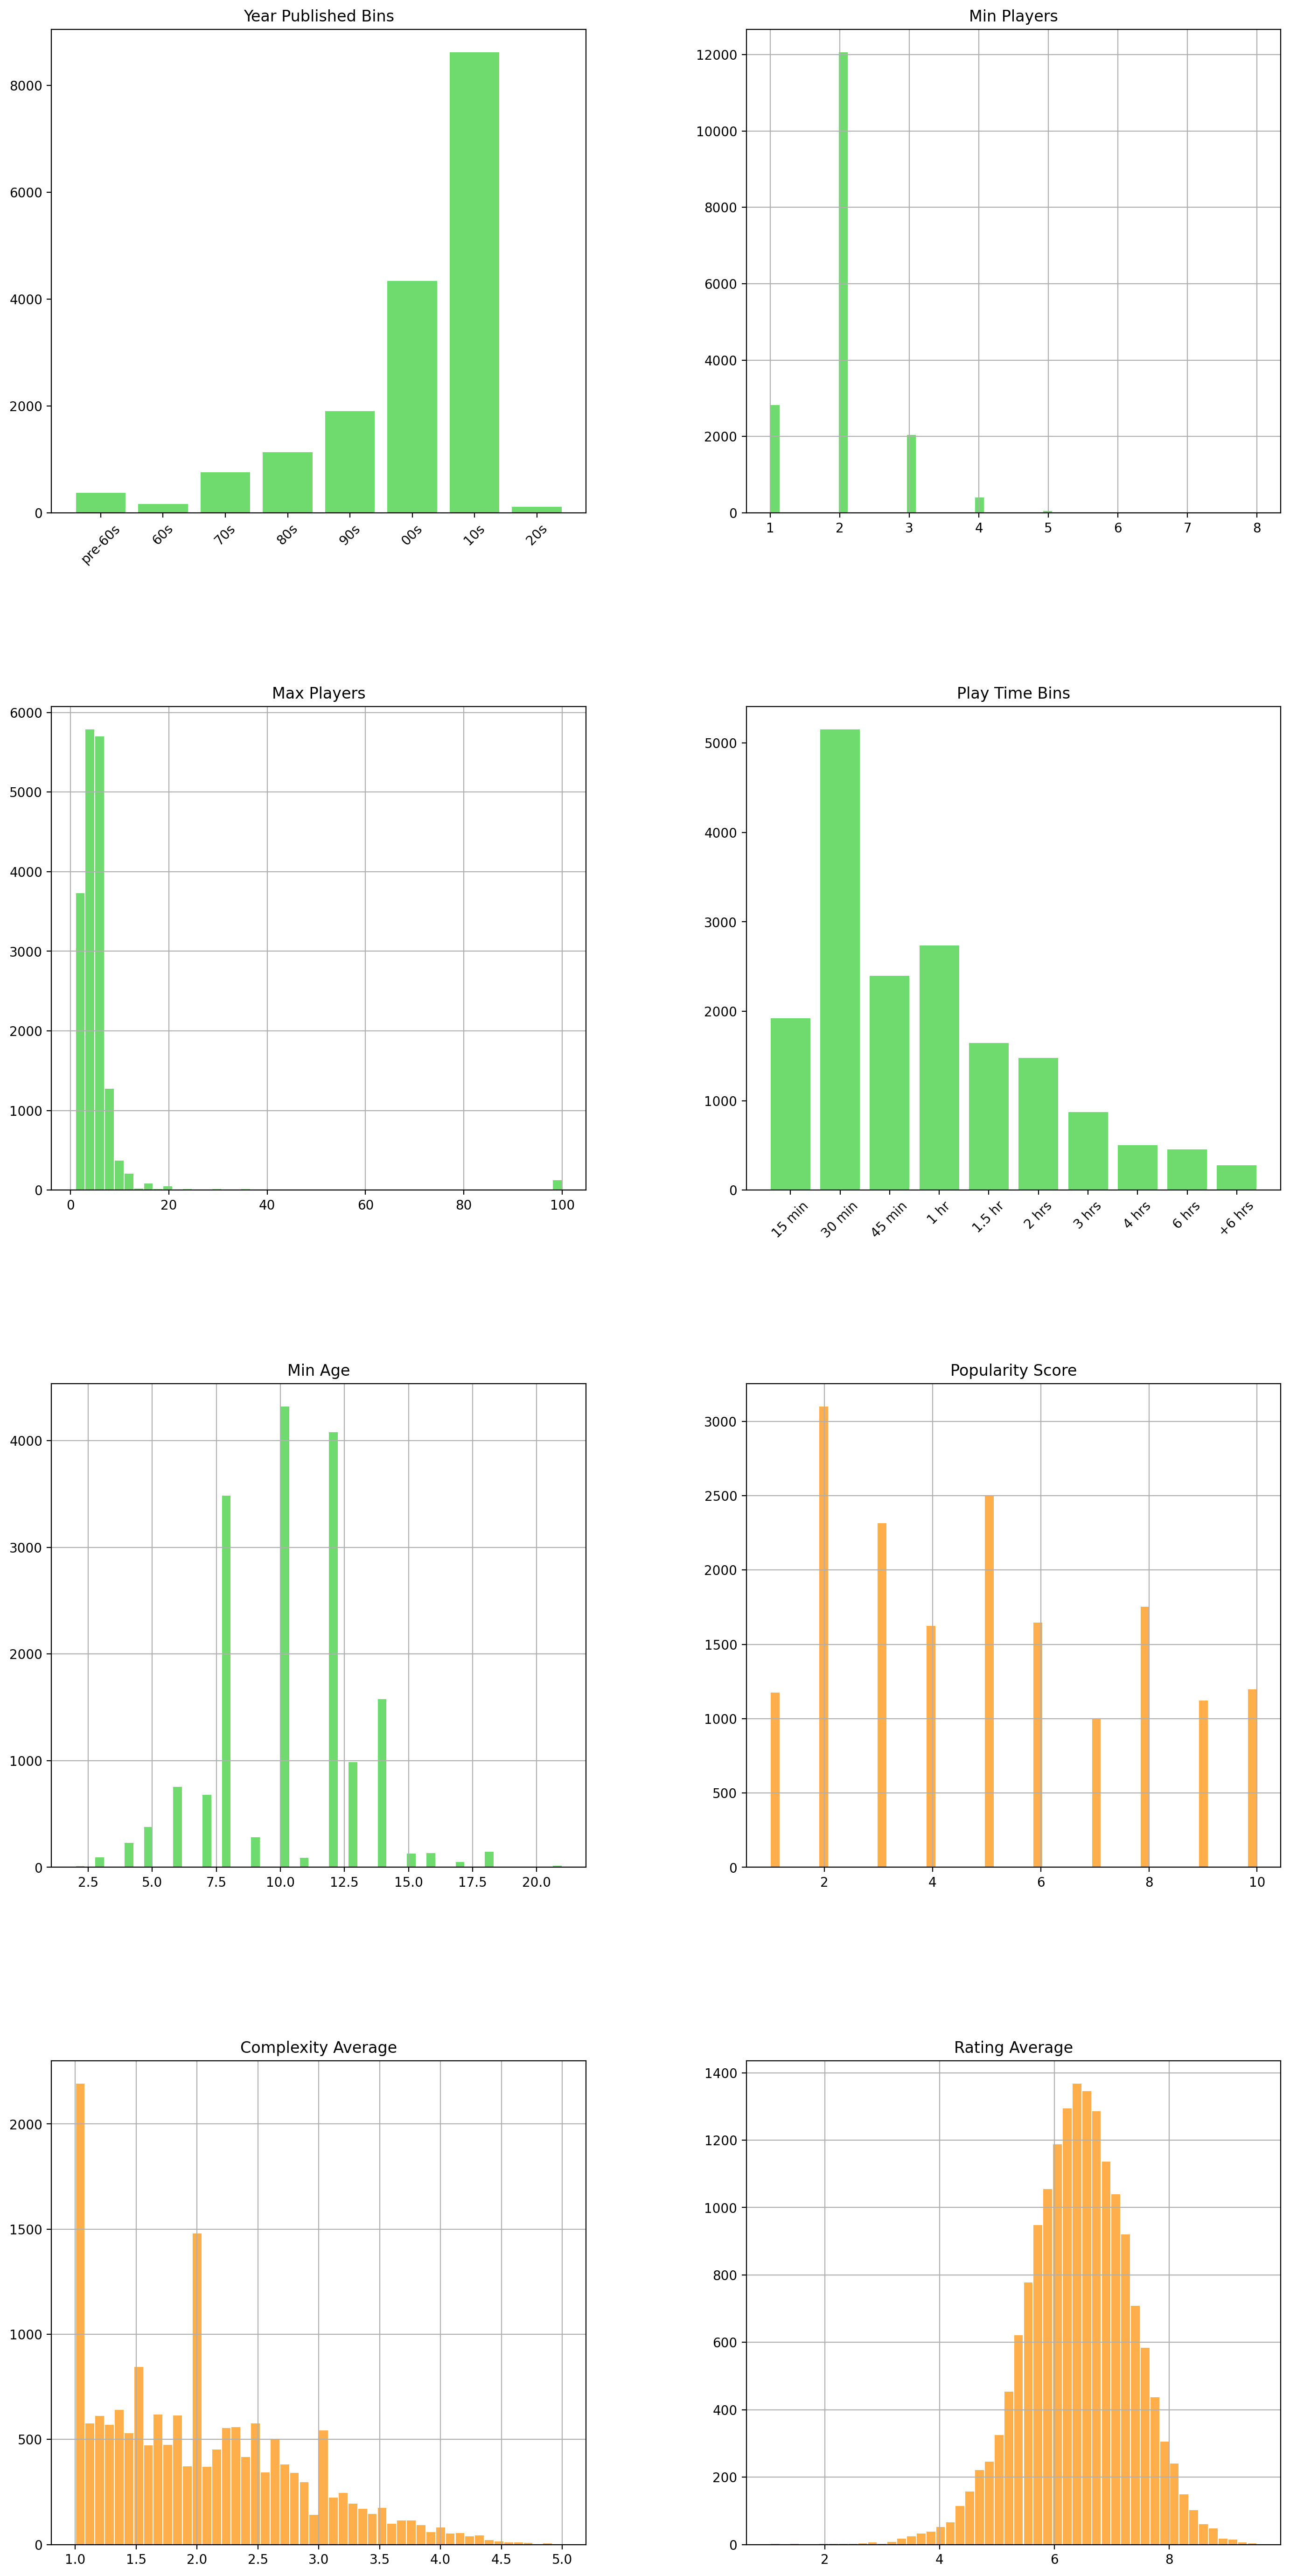

In [25]:
hist_cols = [
    'Year Published Bins',
    'Min Players',
    'Max Players',
    'Play Time Bins',
    'Min Age',
    'Popularity Score',
    'Complexity Average',
    'Rating Average'
]

targets = ['Popularity Score', 'Complexity Average', 'Rating Average']

hist_data = cleaned_data[hist_cols].copy()
fig_cols = 2
fig_rows = ceil(len(hist_cols) / fig_cols)
grid = (fig_rows, fig_cols)

# Create Figure and axes objects
fig, ax = plt.subplots(*grid, figsize=(17, 35), gridspec_kw={'hspace': .4})

# The axes that will be used
used_axes = ax[np.unravel_index(range(len(hist_cols)), grid)]

#Make one histplot per unit of measure 
for i, column in enumerate(hist_cols):
    color = "limegreen" if column not in targets else "darkorange"
    if 'Bins' in column:
        category_counts = hist_data[column].value_counts().sort_index()
        used_axes[i].bar(
            category_counts.index.astype(str),  # Convert categories to strings
            category_counts.values,
            alpha=0.7,
            color=color,
        )
        used_axes[i].set_title(column)
        used_axes[i].tick_params(axis='x', rotation=45)

    else:
        _ = hist_data.hist(
            column=column,
            ax=used_axes[i],
            color=color,
            alpha=0.7,
            bins=50,
            rwidth=0.9)

plt.show(fig)

### 2.8 List Features
#### 2.8.1 Domains

In [26]:
print(f"Empty Data Points: {cleaned_data['Domains'].apply(lambda x: len(x) == 0).sum()}/{cleaned_data.shape[0]}")

doms = cleaned_data['Domains'].explode().value_counts()
print(f"Amount of unique domains: {len(doms)}")
doms

Empty Data Points: 8914/17434
Amount of unique domains: 8


Domains
Wargames              2705
Strategy Games        1886
Family Games          1860
Thematic Games        1004
Abstract Games         890
Children's Games       706
Party Games            521
Customizable Games     245
Name: count, dtype: int64

In [27]:
dom_combs = cleaned_data["Domains"].apply(lambda x: tuple(sorted(x))).value_counts().sort_index()
print(f"Amount of different combinations: {len(dom_combs)}")

dom_combs

Amount of different combinations: 39


Domains
()                                                  8914
(Abstract Games,)                                    720
(Abstract Games, Children's Games)                    21
(Abstract Games, Children's Games, Wargames)           1
(Abstract Games, Customizable Games)                   2
(Abstract Games, Family Games)                        92
(Abstract Games, Party Games)                          4
(Abstract Games, Strategy Games)                      39
(Abstract Games, Strategy Games, Thematic Games)       1
(Abstract Games, Wargames)                            10
(Children's Games,)                                  579
(Children's Games, Family Games)                      96
(Children's Games, Family Games, Party Games)          1
(Children's Games, Party Games)                        4
(Children's Games, Wargames)                           4
(Customizable Games,)                                191
(Customizable Games, Strategy Games)                  23
(Customizable Games, Th

#### 2.8.2 Mechanics

see mechanics_imputation.ipynb for clustering research and imputation

In [28]:
cleaned_data.to_pickle('../data/cleaned_data_wo_mechanics.pkl')

In [32]:
cleaned_data = pd.read_pickle('../data/cleaned_data_with_clusters.pkl')

cleaned_data['Amount_of_Mechanics'] = cleaned_data.apply(lambda row: len(row['Mechanics']), axis=1)

##  3 Correlation Matrix

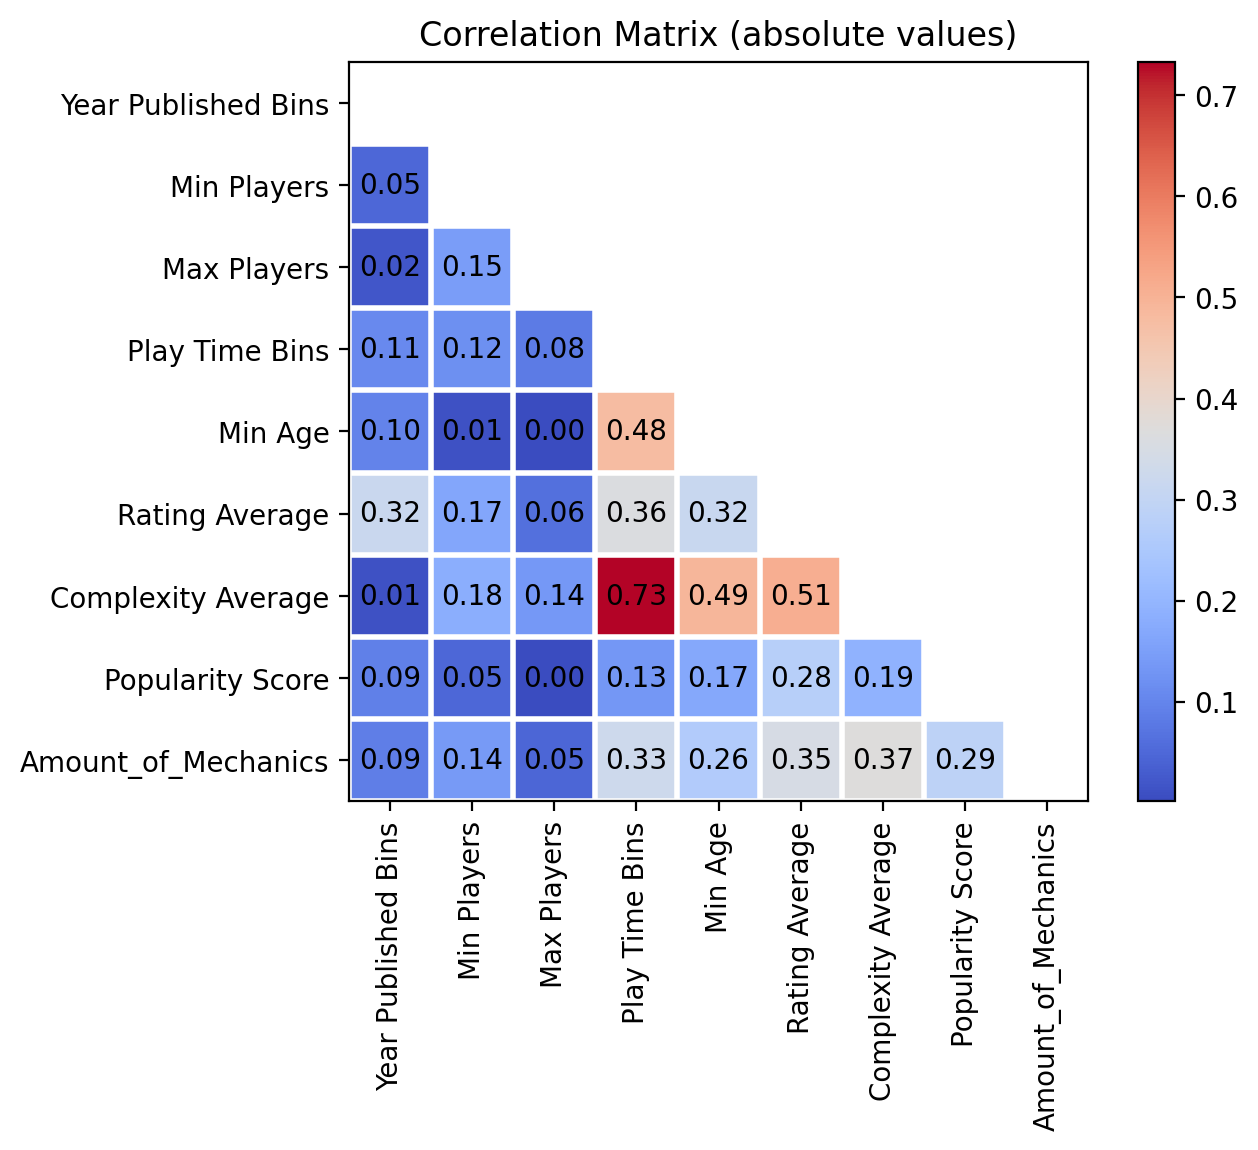

In [33]:
corr_df = cleaned_data.copy().apply(lambda col: col.cat.codes if col.dtypes.name == 'category' else col)
corr_df = corr_df.drop(columns=corr_df.select_dtypes(['object']).columns)
corr = corr_df.corr()
ax_names = corr.columns.tolist()
corr.index = ax_names
corr.columns = ax_names
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

_ = plt.imshow(corr.mask(mask).abs(), cmap='coolwarm', interpolation='nearest')
_ = plt.colorbar()
_ = plt.xticks(np.arange(len(ax_names)), ax_names, rotation=90)
_ = plt.yticks(np.arange(len(ax_names)), ax_names)

plt.grid(False)

_ = plt.xticks(np.arange(-.5, len(ax_names), 1), minor=True)
_ = plt.yticks(np.arange(-.5, len(ax_names), 1), minor=True)
plt.tick_params(which='minor', bottom=False, left=False)
plt.grid(which='minor', color='w', linestyle='-', linewidth=2)

# Display the correlation values on the matrix
for i in range(len(ax_names)):
    for j in range(len(ax_names)):
        # Check if the value is not masked (in the upper triangle)
        if not mask[i, j]:
            # Display the correlation value (rounded for readability)
            _ = plt.text(j, i, f'{abs(corr.iloc[i, j]):.2f}', ha='center', va='center', color='black')

_ = plt.title("Correlation Matrix (absolute values)")

hoge waardes tussen : 
- complexity en min age
- complexity en rating average


## 4. Export Cleaned Data

In [34]:
cleaned_data.to_pickle('../data/cleaned_data.pkl')